In [1]:
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import numpy as np
import control as ct
import sympy as sp

plt.style.use('maroon_ipynb.mplstyle')

From lecture 12 notes, the circuit in the first example resulted in the following differential equation:

$$0.24\ddot{i}_0 + 4\dot{i}_0 + 400i_0=5\cos{50t}$$

In [2]:
t, s = sp.symbols('t s')
i0 = sp.Function('i_0')(t)
vs = sp.Function('v_s')(t)

# For decimals, pass in the decimal as a string into sp.S() function
eq = sp.Eq(sp.S('0.24')*i0.diff(t, 2) + 4*i0.diff() + 400*i0, vs.diff())
eq

Eq(400*i_0(t) + 4*Derivative(i_0(t), t) + 0.24*Derivative(i_0(t), (t, 2)), Derivative(v_s(t), t))

Putting it in the state variable form:

In [3]:
i1 = sp.Function('i_1')(t)

# Define new equation (state variable equations)
eq2 = sp.Eq(i0.diff(), i1)

# Re-write first equation in terms of new state variable
subs = [
    (i0.diff(t, 2), i1.diff()),
    (i0.diff(), i1)
]
eq1 = eq.subs(subs)

# Solve it
sol = sp.solve([eq1, eq2], [i0.diff(), i1.diff()], dict=True)[0]
for key, value in sol.items():
    display(sp.Eq(key, value.nsimplify()))  # nsimplify() converts to fractions

Eq(Derivative(i_0(t), t), i_1(t))

Eq(Derivative(i_1(t), t), -5000*i_0(t)/3 - 50*i_1(t)/3 + 25*Derivative(v_s(t), t)/6)

In [4]:
def state_vars(i, t_):
    return [
        i[1],
        -5000/3*i[0] - 50/3*i[1] + 25/6*5*np.cos(50*t_)
    ]

Getting the transfer function:

In [5]:
def lp(expr): return sp.laplace_transform(expr, t, s)[0]

# Take laplace of both sides
eq_s = sp.Eq(lp(eq.lhs), lp(eq.rhs))

# Make initial conditions zero
sub_ics = [
    (i0.subs(t, 0), 0),
    (i0.diff().subs(t, 0), 0),
    (vs.subs(t, 0), 0)
]
eq_s = eq_s.subs(sub_ics)

# Solve for output over input
sol = sp.solve(eq_s, lp(i0))[0]
sol/lp(vs)

12.5*s/(3.0*s**2 + 50.0*s + 5000.0)

In [6]:
tf = ct.tf([12.5, 0], [3, 50, 5000])
tf

TransferFunction(array([12.5,  0. ]), array([   3,   50, 5000]))

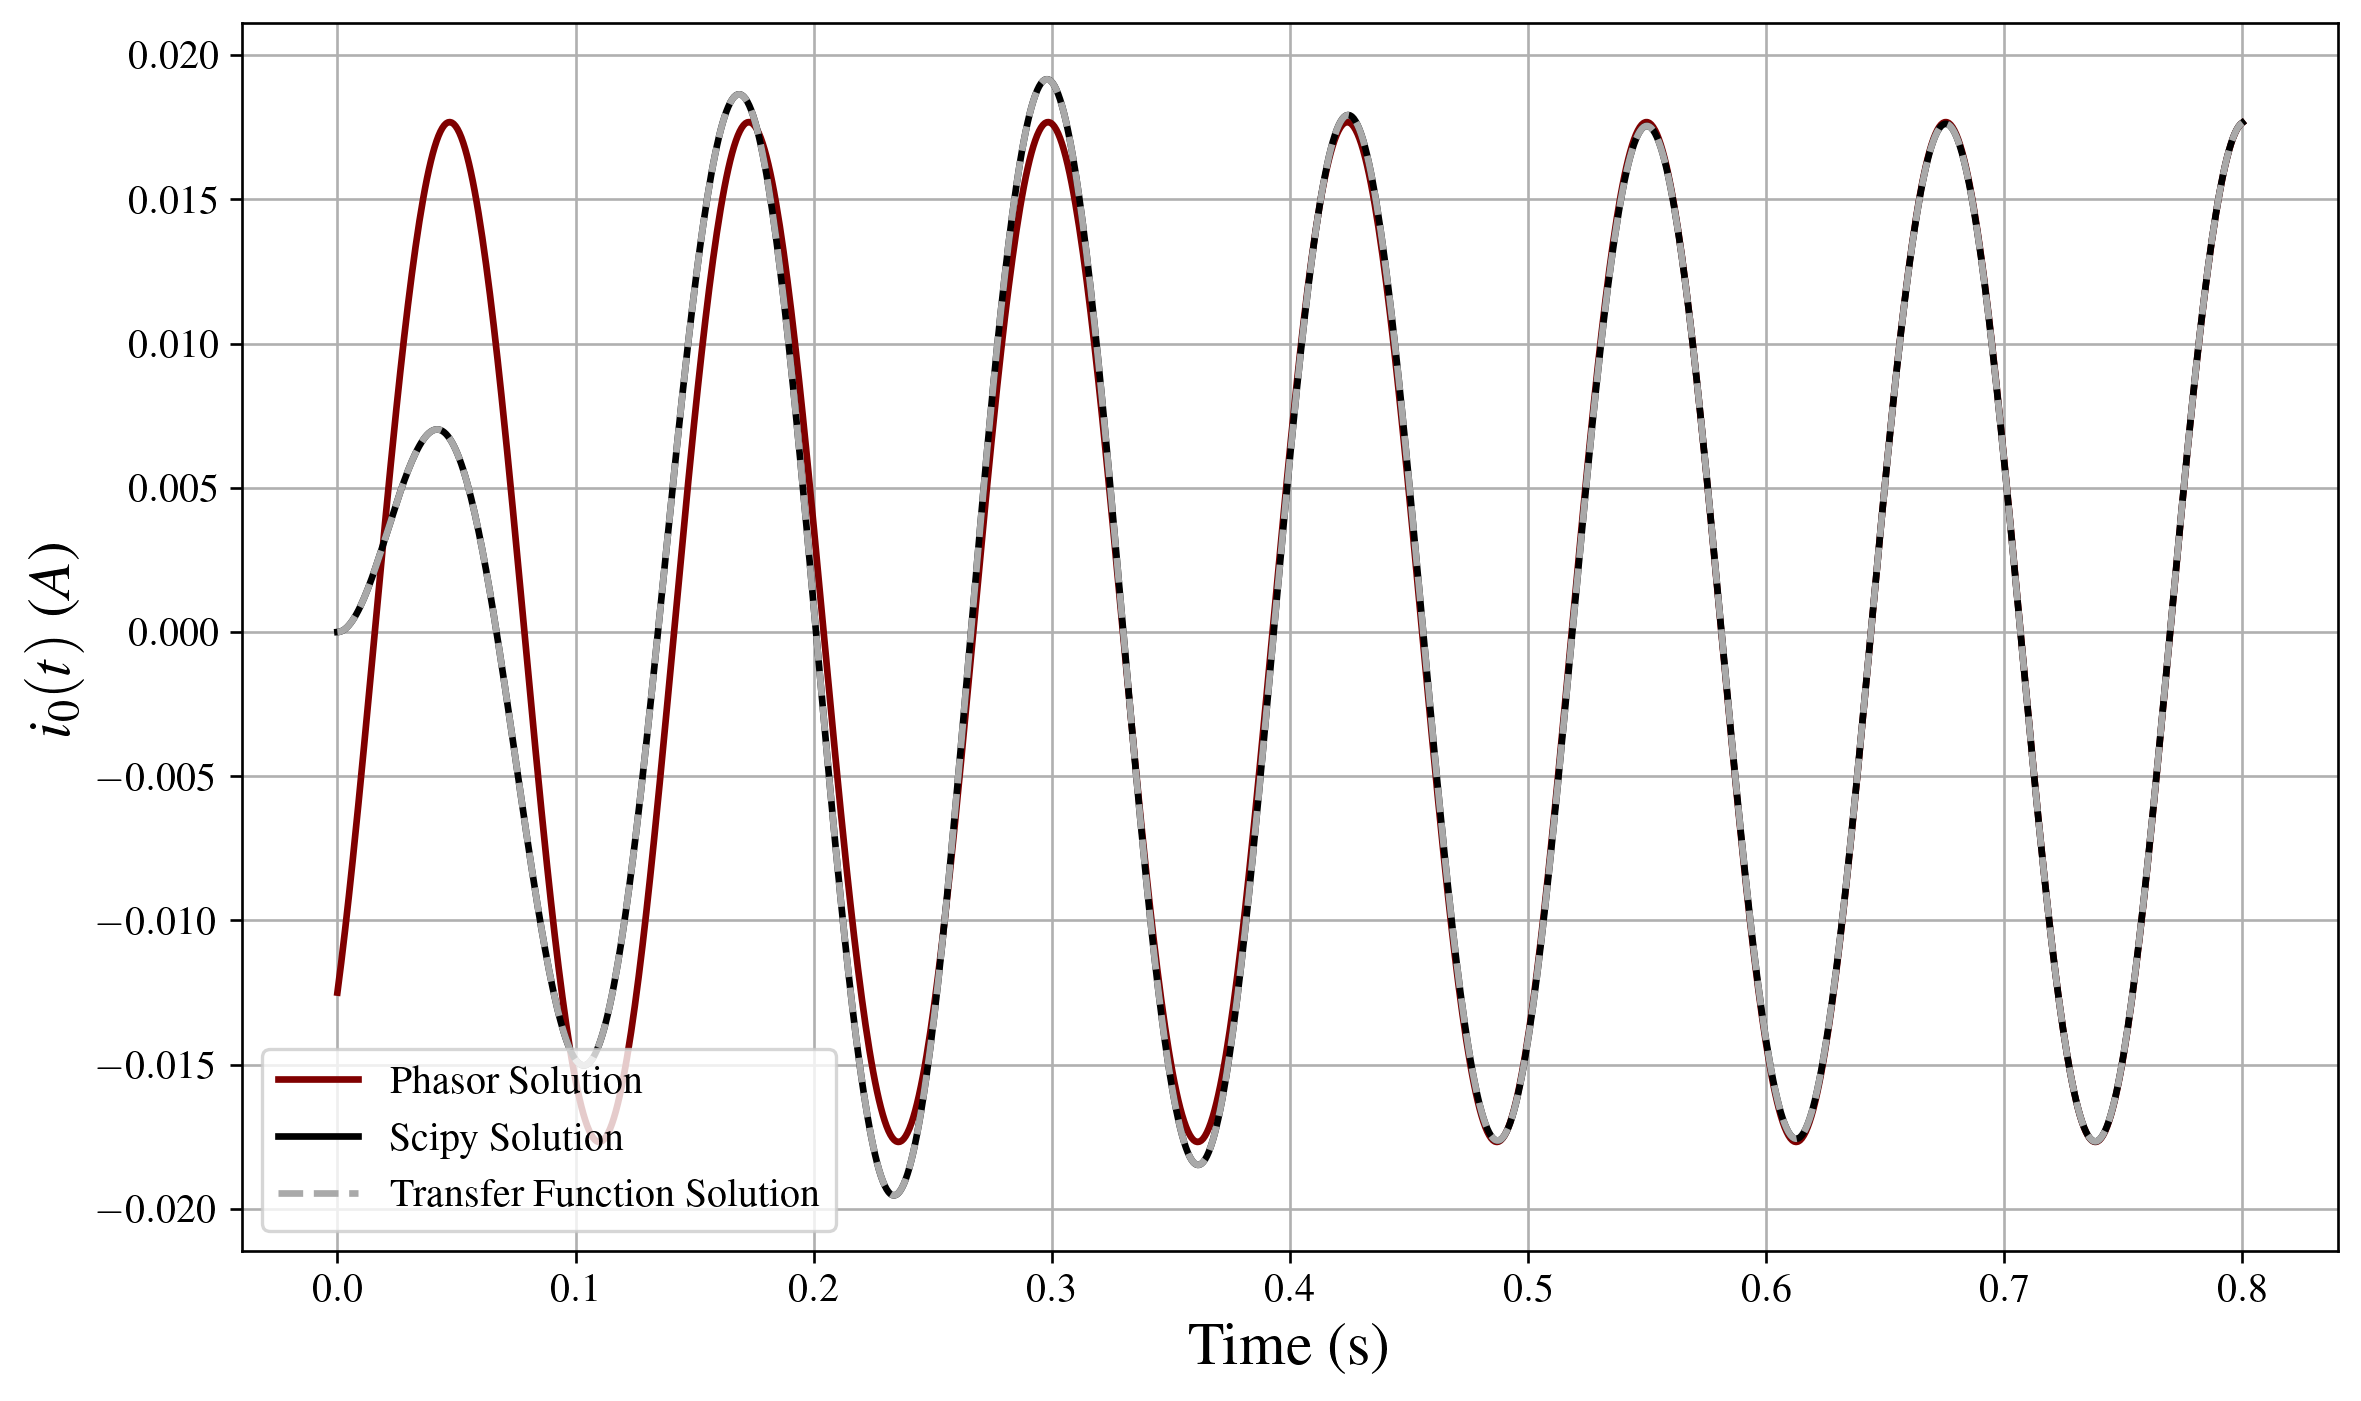

In [7]:
# Plot the response
f = lambda t_: 0.017678*np.cos(50*t_ - np.deg2rad(135))  # From circuits class (using phase domain)
t_array = np.linspace(0, 0.8, 1000)

# State variable solution
sv_sol = odeint(state_vars, (0, 0), t_array)

# Transfer function solution
_, tf_sol = ct.forced_response(tf, T=t_array, U=0.1*np.sin(50*t_array))

plt.plot(t_array, f(t_array), label='Phasor Solution')
plt.plot(t_array, sv_sol[:, 0], label='Scipy Solution')
plt.plot(t_array, tf_sol, ls='--', label='Transfer Function Solution')

plt.xlabel('Time (s)')
plt.ylabel('$i_0(t)$  ($A$)')
plt.legend()
plt.show()

Note: The circuits class made use of phasors, which is only applicable to AC circuits, and it only solves for the steady state response.